In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [5]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
T = 10.0

from src.energies.lennardjones_energy import LennardJonesEnergy, lennard_jones_energy_torch
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=T
    )

## Function Definitions

In [6]:
def rademacher(shape, dtype=torch.float32, device='cuda'):
    """Sample from Rademacher distribution."""
    rand = ((torch.rand(shape) < 0.5)) * 2 - 1
    return rand.to(dtype).to(device)

In [7]:
def _compute_laplacian_hutchinson(nabla_Ut, t, xt):
    # Compute the noise
    noise = rademacher(xt.shape, dtype=torch.float32, device=device)
    # Compute the jvp of the nabla_Ut and the noise
    jvp = torch.autograd.grad(nabla_Ut, xt, noise, create_graph=True)[0] # nabla(nabla_Ut) * noise
    laplacian = (jvp * noise).sum(-1)
    return laplacian.detach()


def compute_laplacian_hutchinson(nabla_Ut, t, xt, n_samples):
    laplacian = 0
    for _ in range(n_samples):
        laplacian += _compute_laplacian_hutchinson(nabla_Ut, t, xt)
    return laplacian / n_samples

In [8]:
def compute_laplacian(model, t, xt): 
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0)).squeeze()
    
    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(hessian(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()

In [31]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, noise_schedule):
        super().__init__()
        self.model = model
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, T=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)
            epsilon_t = self.g(t, x).pow(2) / 2 

            nabla_Ut = self.model(t, x)
            drift_X = nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None or t[0]>0.7:
                return  drift_X, drift_A
            
            laplacian_b = compute_laplacian_hutchinson(nabla_Ut, t, x, 50)
            # laplacian_b = compute_laplacian(self.model, t, x)
            drift_A = epsilon_t * (nabla_Ut.pow(2).sum(-1) * 2 * (T-1) / T +  laplacian_b *  (T-1))
        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval, T):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, T)
    drift_Xt = drift_Xt * dt * T
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device) / sqrt(T)

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next

    #resample based on the weights
    choice = torch.multinomial(torch.softmax(a_next, dim=-1), x.shape[0], replacement=True)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval, T):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step, resampling_interval, T)
            x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, resampling_interval=None, T=1.0):
    integrator = integrate_sde_coupled
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrator(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        T=T
    )
    return samples[-1], weights

In [10]:
# sample from a tensor
def sample_from_tensor(tensor, num_samples):
    idx = torch.randint(0, tensor.shape[0], (num_samples,))
    return tensor[idx]


# calculate the log expectation of the reward
def log_E_R(_x, _t, energy, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t) 
    h_t = h_t.unsqueeze(1)

    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    # log_rewards = target(target.unnormalize(samples))
    log_rewards = energy(samples)
    log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R


def estimate_grad_Rt(xt,
                     t,
                     energy,
                     noise_schedule,
                     num_mc_samples=100):
    est_scores_n = torch.func.grad(log_E_R)(xt, t, energy, noise_schedule, num_mc_samples)
    return est_scores_n

In [11]:
def reward_matching_loss(estimator,
                         model,
                         energy,
                         x,
                         t,
                         noise_schedule,
                         num_mc_samples=100,
                         clip=True
    ):


    x.requires_grad = True

    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)


    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = torch.vmap(estimator, randomness="different",
                                  in_dims=(0, 0, None, None))(
                                    xt,
                                    t,
                                    energy,
                                    noise_schedule,
                                    num_mc_samples=num_mc_samples,
    ).detach()


    if clip:
        estimated_scores = estimated_scores.view(-1, target.n_particles, target.n_spatial_dim)
        estimated_scores = clipper.clip_scores(estimated_scores)
        estimated_scores = estimated_scores.view(-1, target.n_particles * target.n_spatial_dim)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Training

In [12]:
from src.models.components.noise_schedules import GeometricNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=3)

prior samples torch.Size([1024, 39])


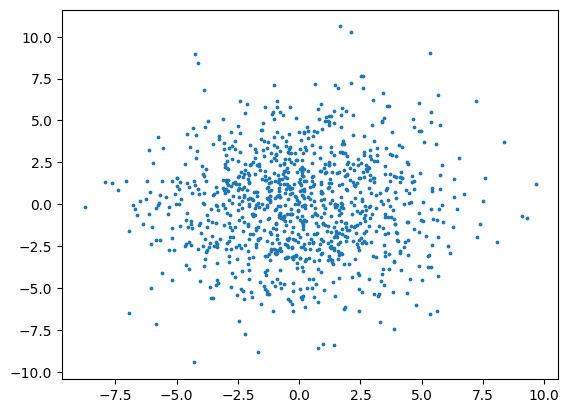

In [13]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(1024).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

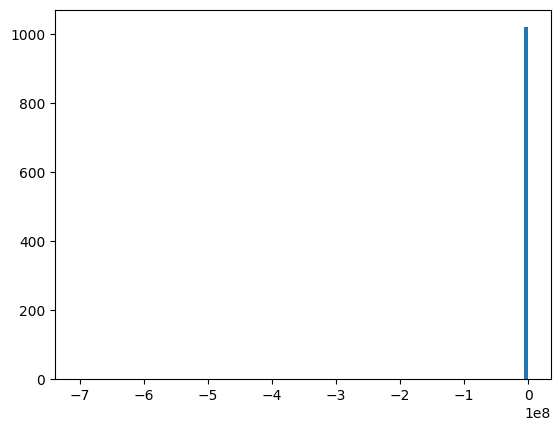

In [14]:
x1_enegry = target(x1_samples, T=1.0)
plt.hist(x1_enegry.detach().cpu().numpy(), bins=100);

In [24]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [25]:
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=100
)

In [26]:
outer_epochs= 100
inner_epochs = 100

batch_size = 256

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 500

In [29]:
from src.models.components.egnn import EGNN_dynamics
score_net = EGNN_dynamics(n_particles=target.n_particles,
                          n_dimension=target.n_spatial_dim,
                          hidden_nf=32,
                          act_fn=torch.nn.SiLU(),
                          n_layers=3,
                          recurrent=True,
                          tanh=True,
                          attention=True,
                          condition_time=True,
                          agg='sum').to(device)


model = score_net
optimizer = Adam(model.parameters(), lr=1e-3)
weighted = False

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 5.718840
Epoch 49 | Loss 7.567658
Epoch 98 | Loss 6.126418


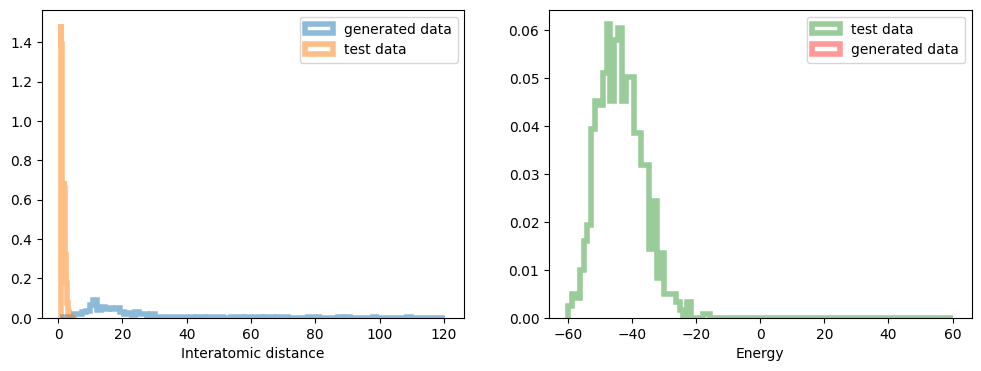

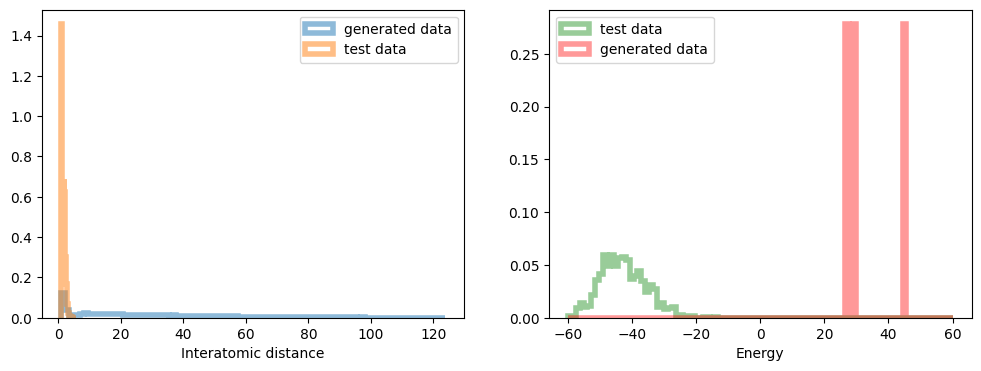

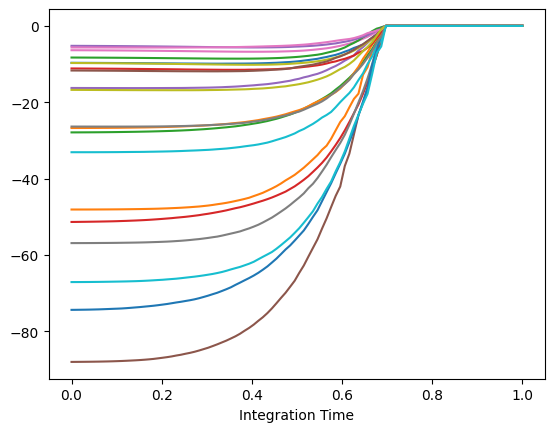

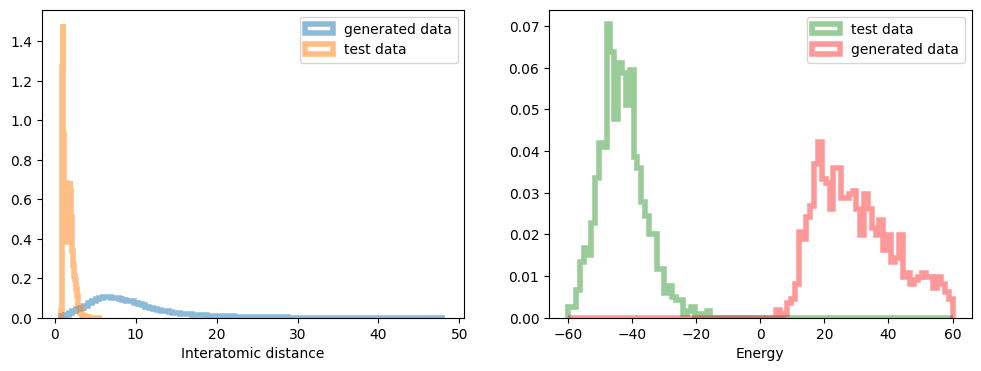

  1%|          | 1/100 [00:49<1:21:24, 49.34s/it]

Mean of Energy tensor(-32.7377, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 3.186707
Epoch 49 | Loss 2.621213
Epoch 98 | Loss 0.288887


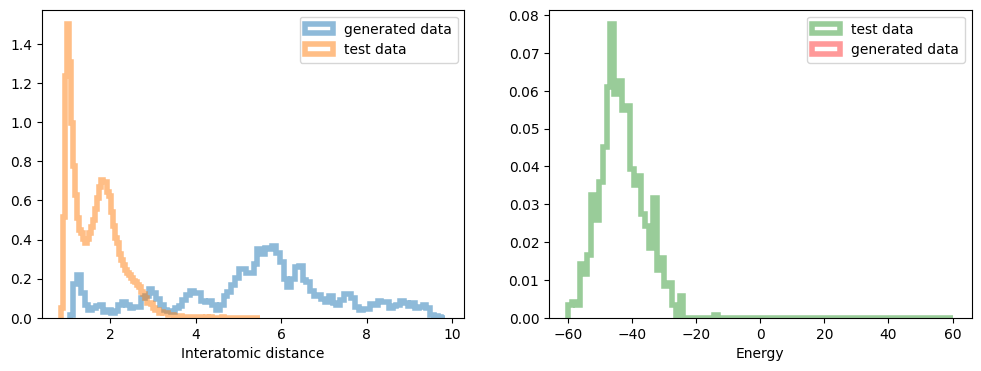

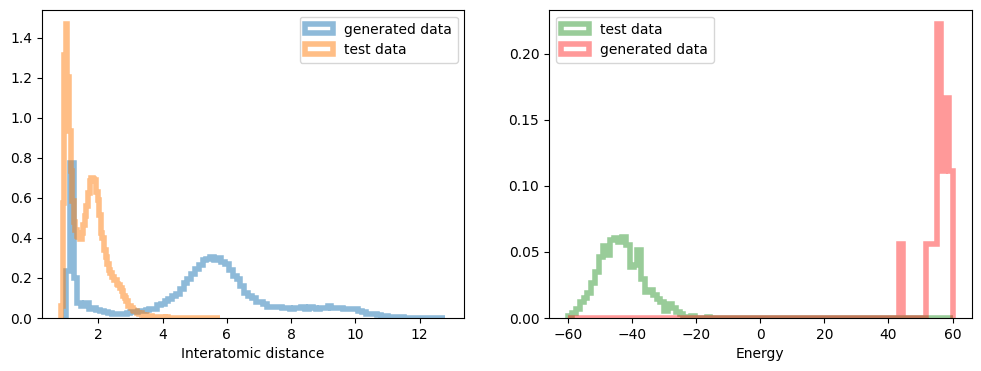

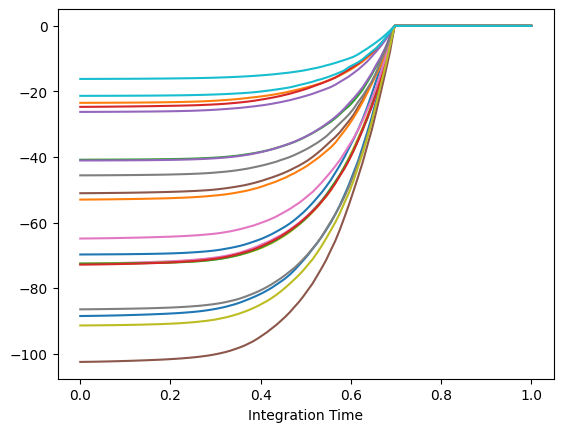

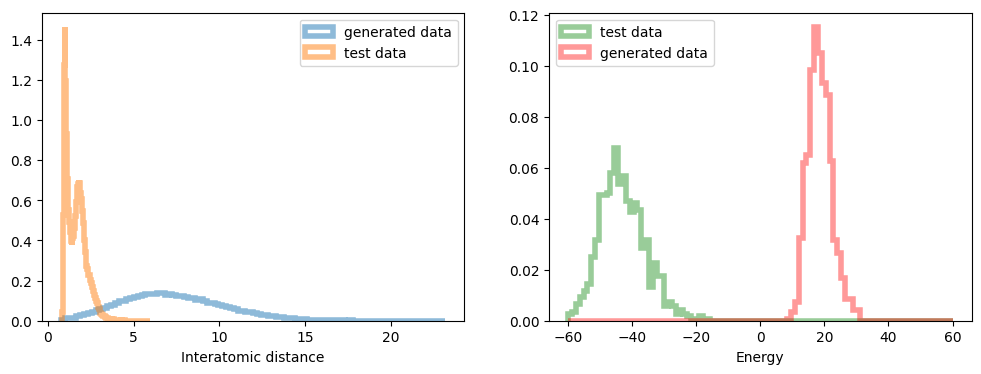

  2%|▏         | 2/100 [02:07<1:48:29, 66.42s/it]

Mean of Energy tensor(-18.6449, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.860565
Epoch 49 | Loss 0.353087
Epoch 98 | Loss 0.836385


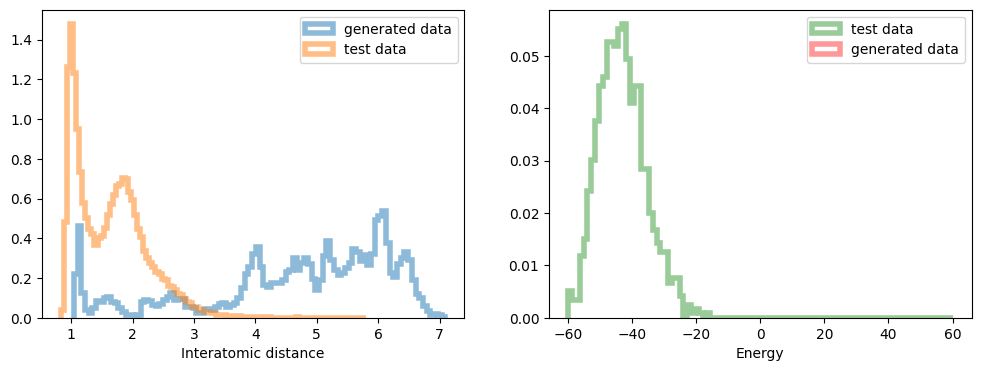

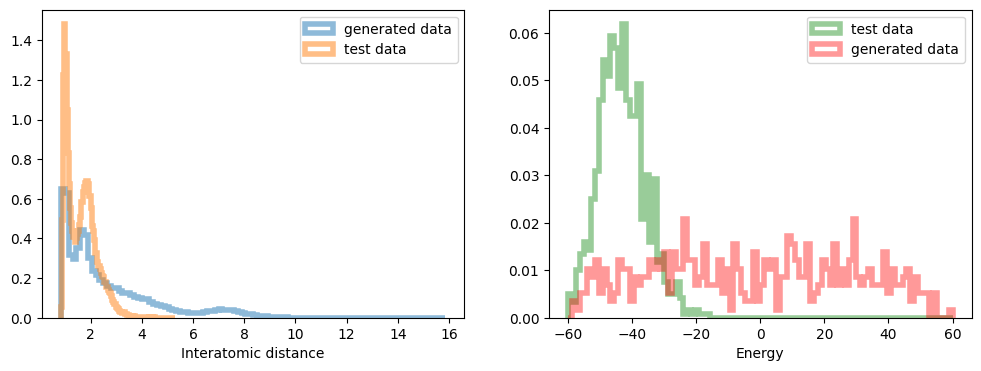

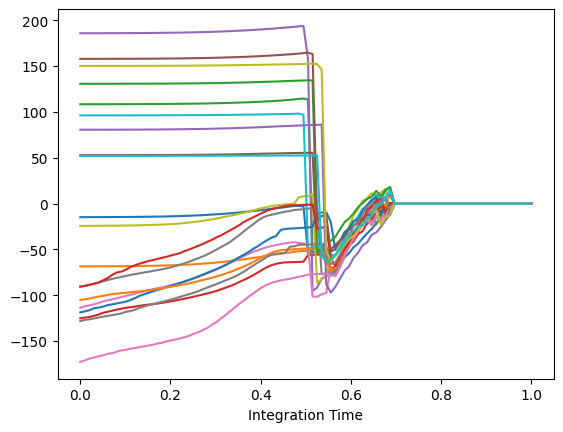

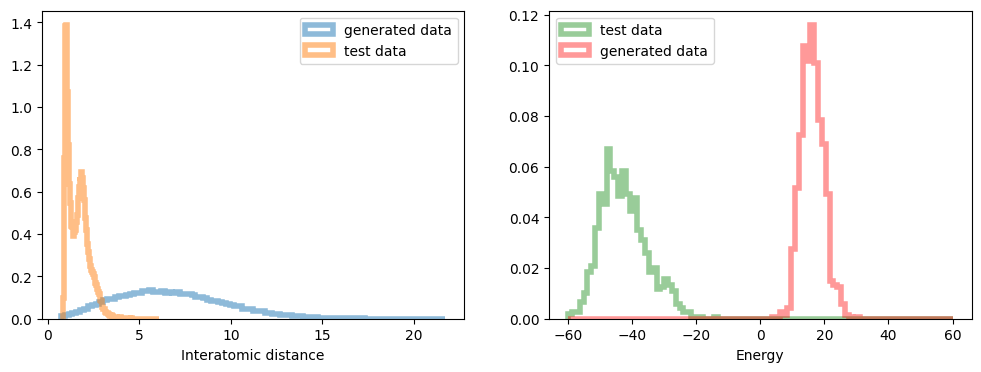

  3%|▎         | 3/100 [03:25<1:55:30, 71.45s/it]

Mean of Energy tensor(-16.2601, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.639705
Epoch 49 | Loss 0.602698
Epoch 98 | Loss 0.361526


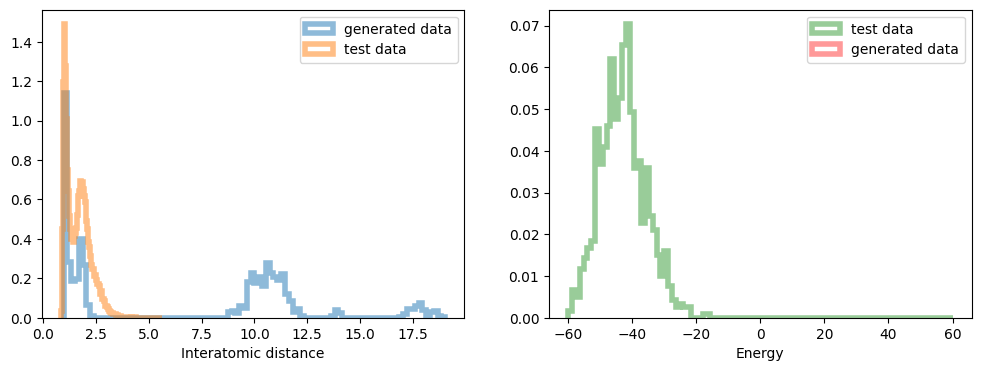

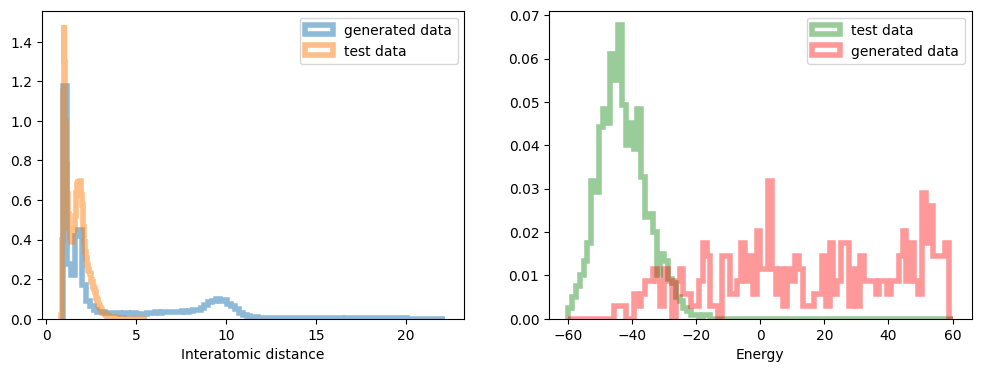

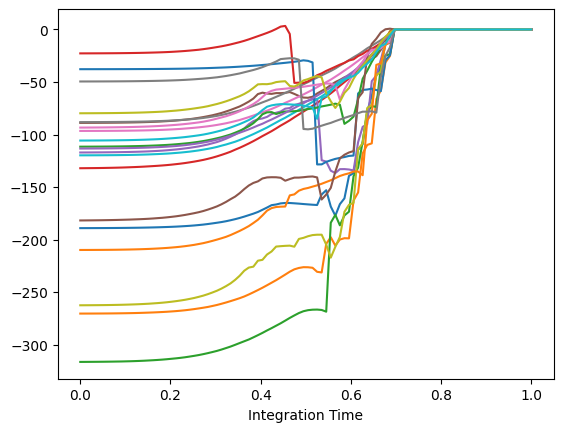

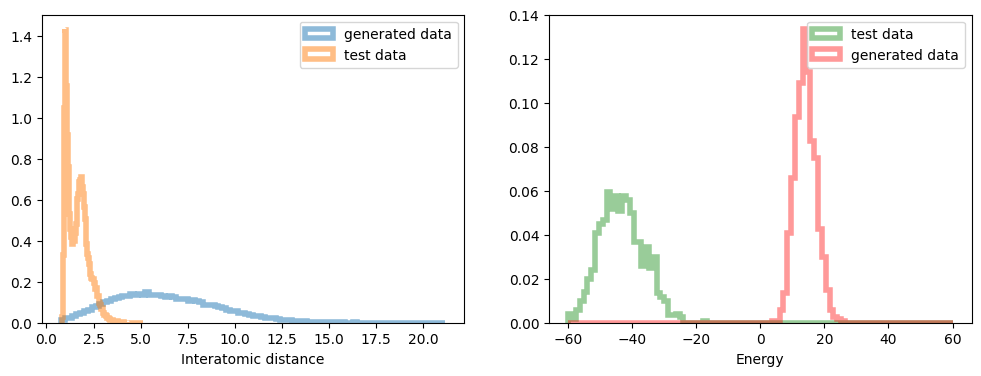

  4%|▍         | 4/100 [04:43<1:58:23, 73.99s/it]

Mean of Energy tensor(-14.1173, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.090808
Epoch 49 | Loss 0.085477
Epoch 98 | Loss 0.728007


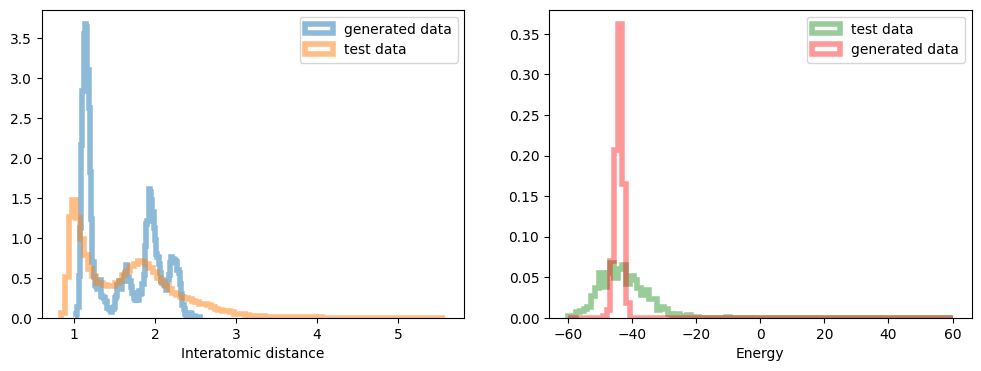

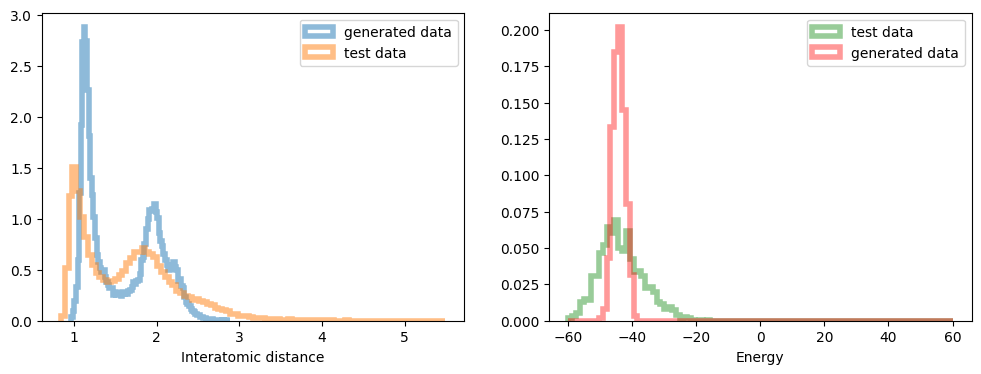

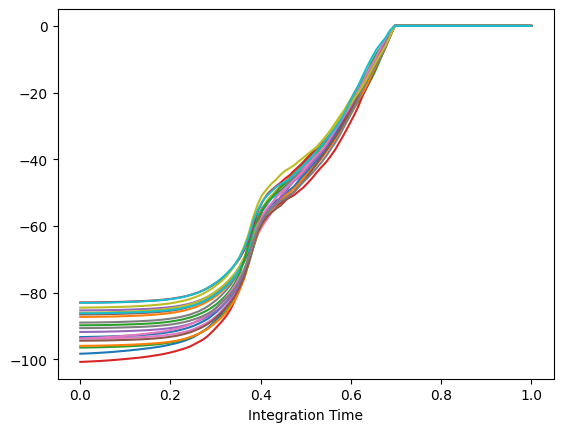

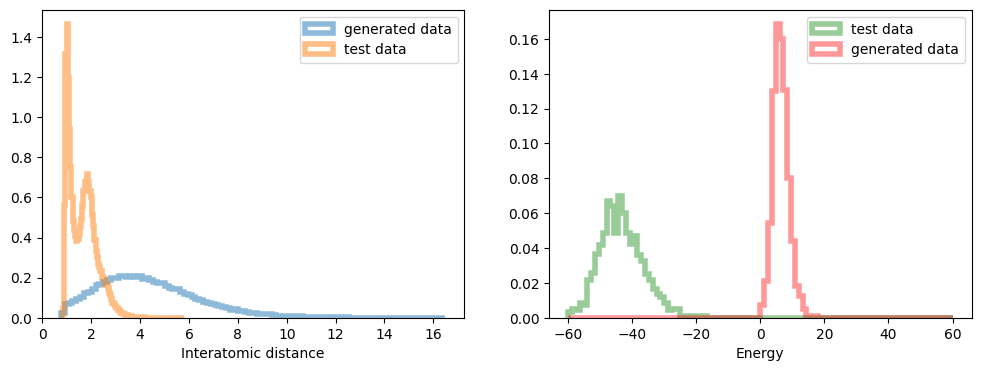

  5%|▌         | 5/100 [06:01<1:59:32, 75.50s/it]

Mean of Energy tensor(-6.4432, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.688933
Epoch 49 | Loss 0.287098
Epoch 98 | Loss 0.545999


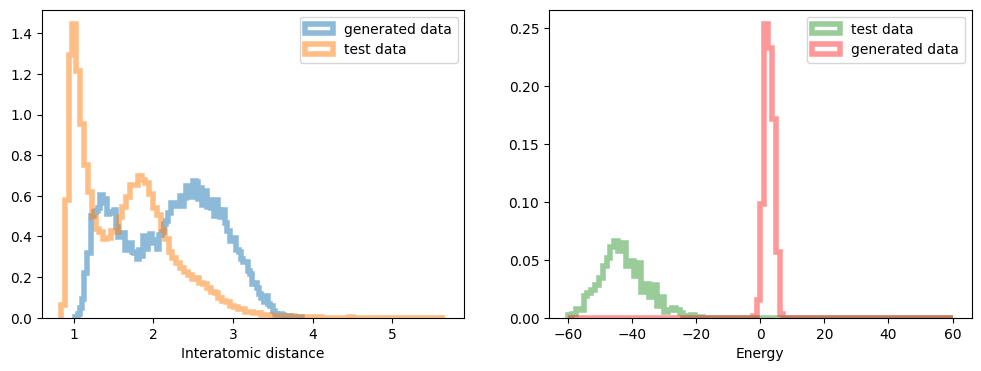

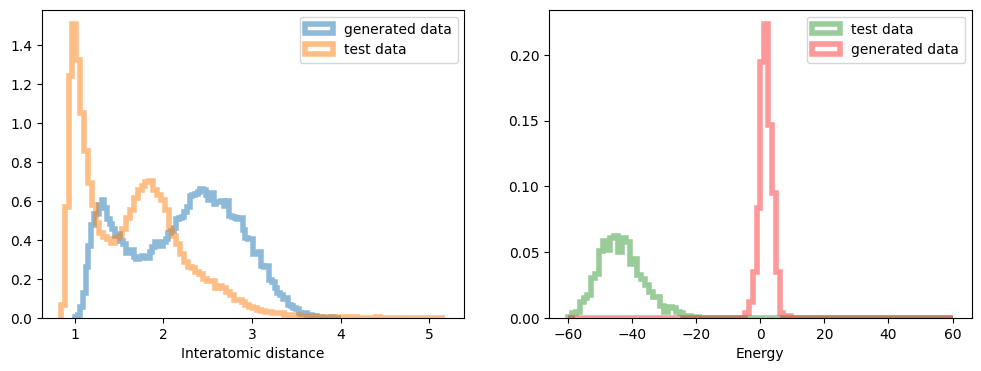

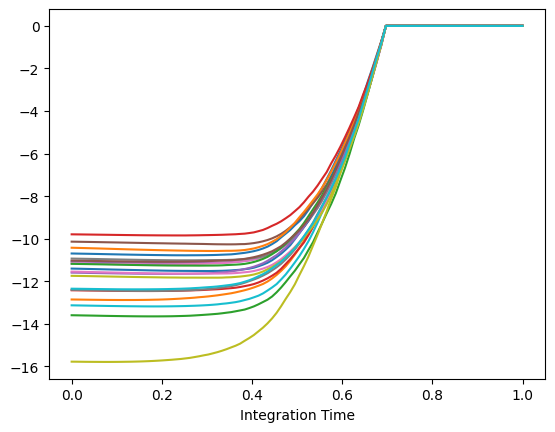

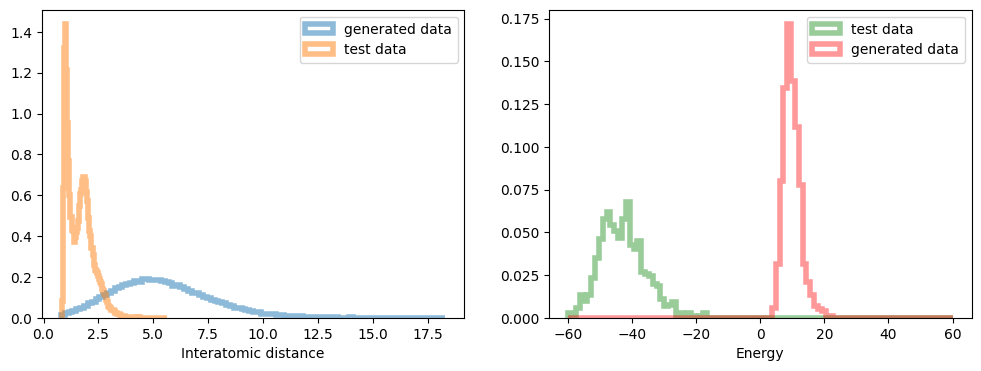

  6%|▌         | 6/100 [07:18<1:59:17, 76.15s/it]

Mean of Energy tensor(-9.8930, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.066402
Epoch 49 | Loss 0.051357
Epoch 98 | Loss 0.055048


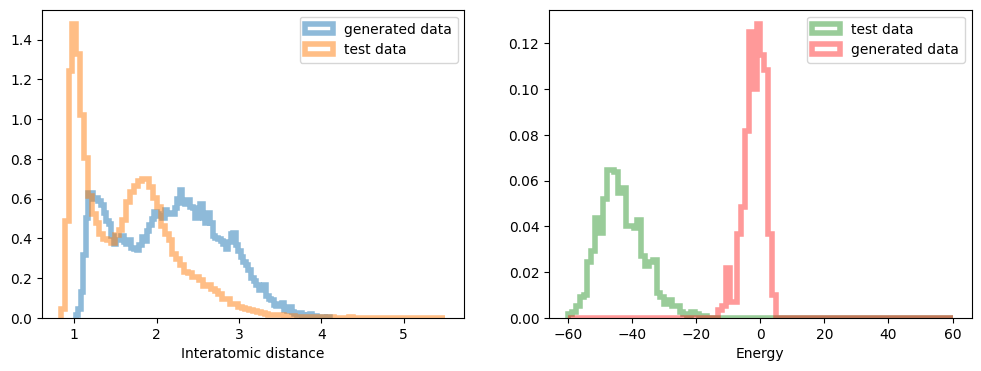

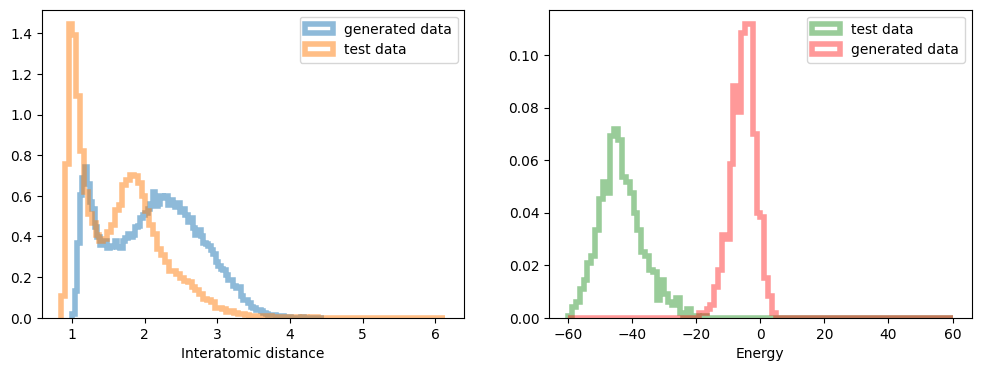

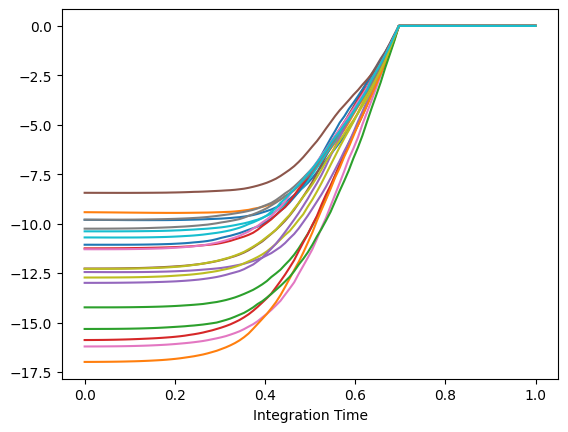

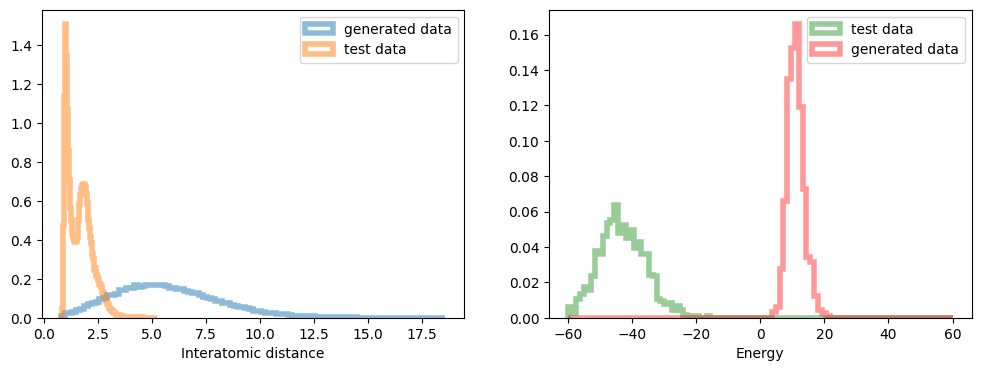

  7%|▋         | 7/100 [08:37<1:59:12, 76.91s/it]

Mean of Energy tensor(-11.1498, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.578635
Epoch 49 | Loss 0.107855
Epoch 98 | Loss 0.104174


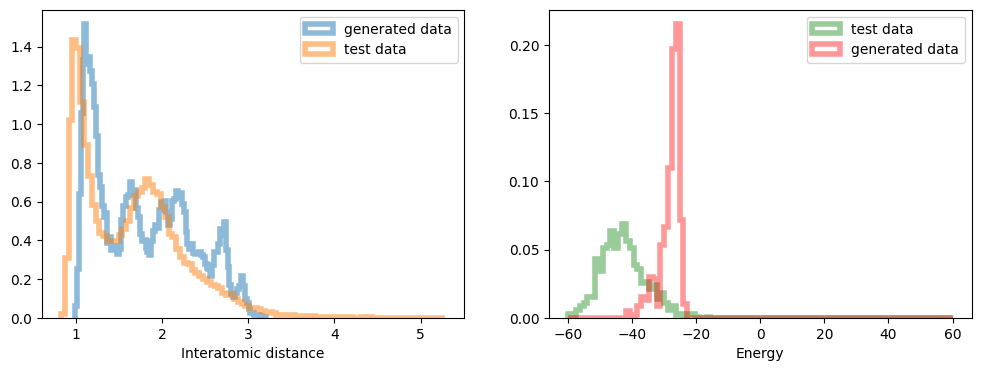

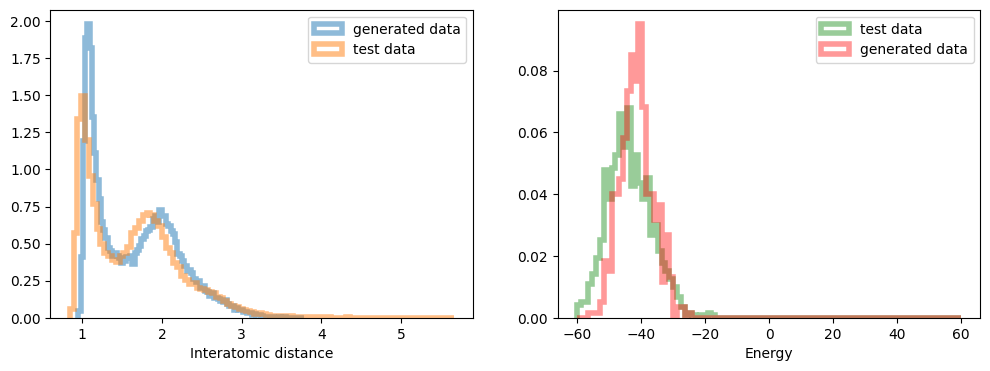

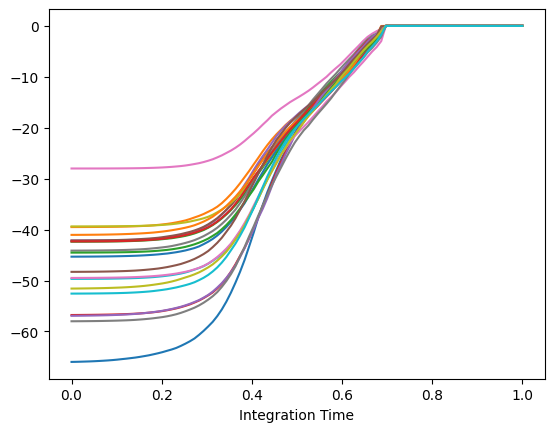

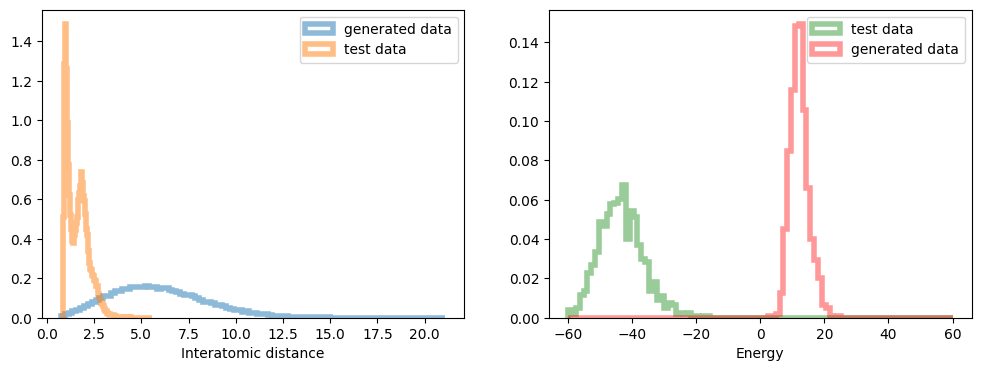

  8%|▊         | 8/100 [09:55<1:58:43, 77.43s/it]

Mean of Energy tensor(-12.2719, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.026602
Epoch 49 | Loss 0.279176
Epoch 98 | Loss 0.103031


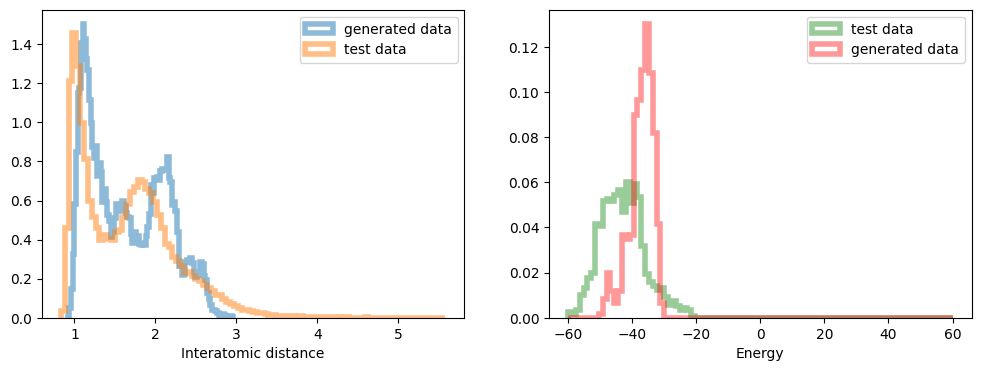

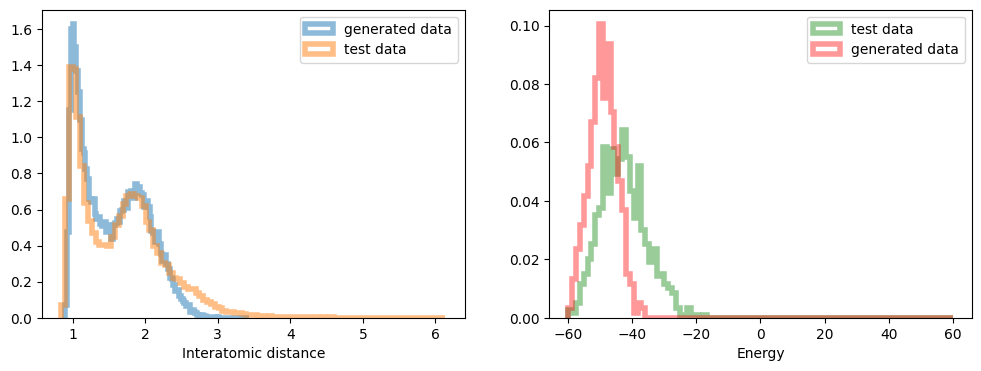

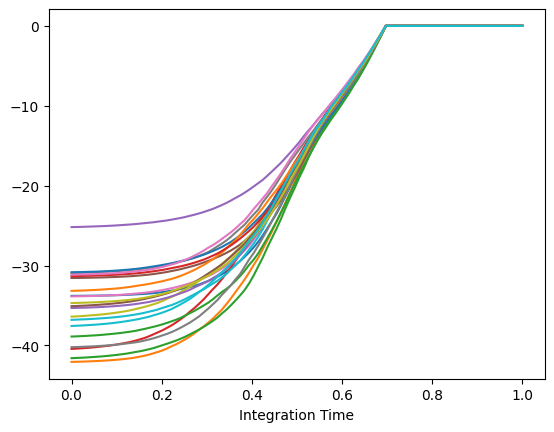

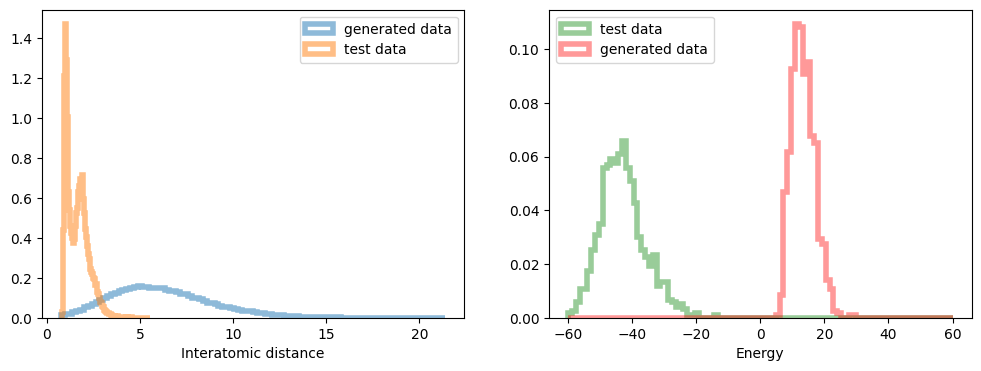

  9%|▉         | 9/100 [11:13<1:57:32, 77.50s/it]

Mean of Energy tensor(-13.4550, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.035113
Epoch 49 | Loss 0.024878
Epoch 98 | Loss 0.021404


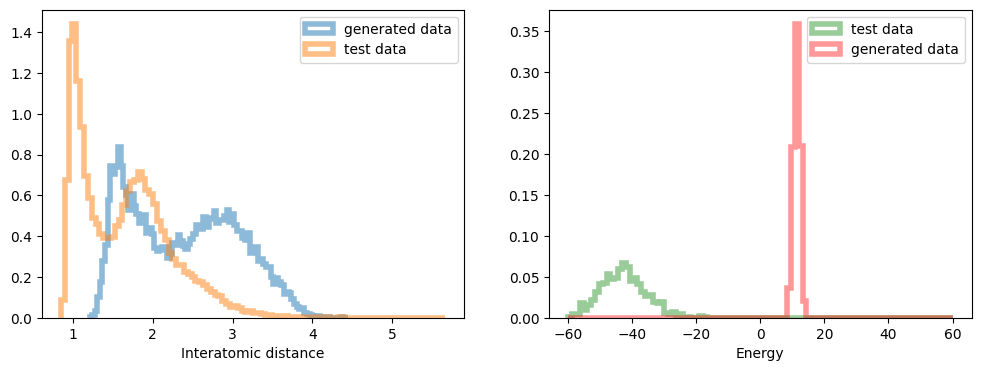

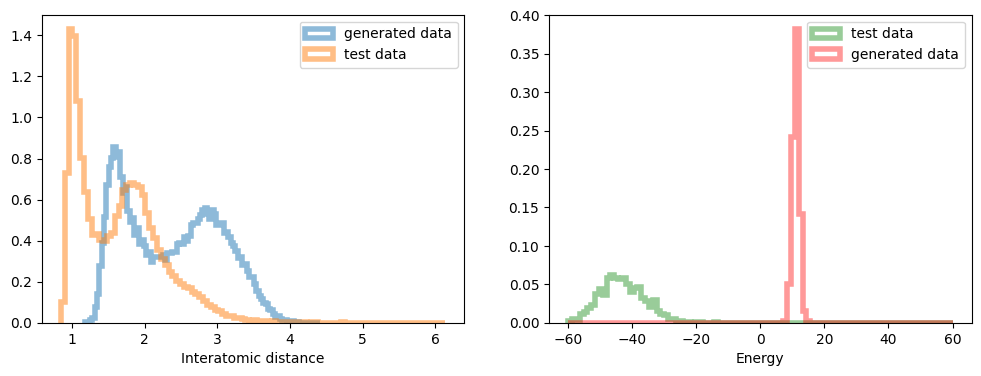

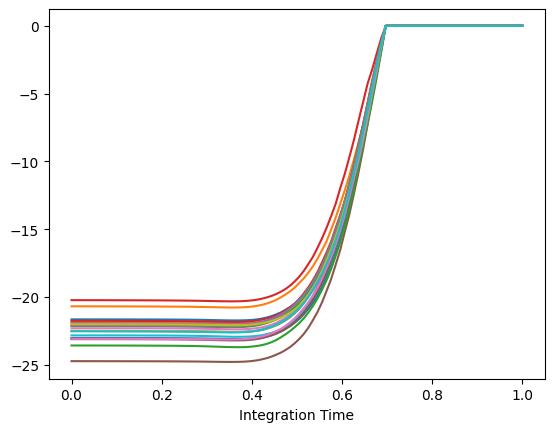

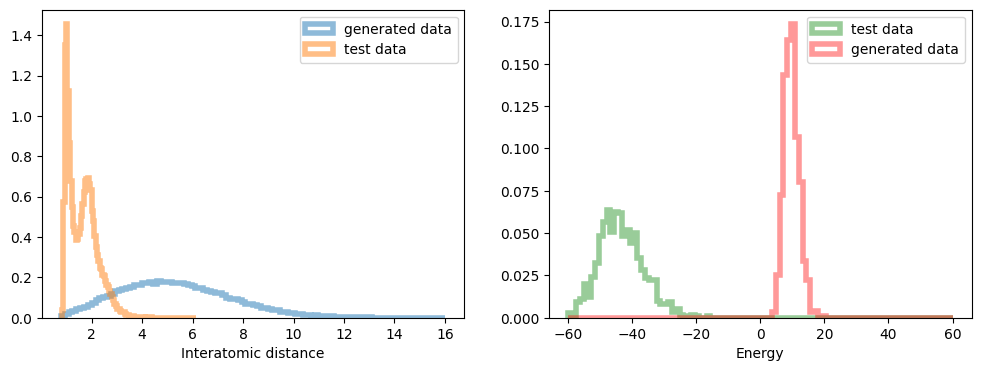

 10%|█         | 10/100 [12:33<1:57:31, 78.35s/it]

Mean of Energy tensor(-9.8016, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 0.019752
Epoch 49 | Loss 0.023871
Epoch 98 | Loss 0.018123


 10%|█         | 10/100 [13:23<2:00:34, 80.39s/it]


KeyboardInterrupt: 

In [32]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)

            rm_loss= reward_matching_loss(estimate_grad_Rt,
                                          model, 
                                          target,
                                          samples,
                                          t, 
                                          noise_schedule, 
                                          num_mc_samples=num_mc_samples,
                                          clip=True
                                          )
            

            
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


        # if epoch % 49 == 0:


    # for plotting
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    prior_samples = prior.sample(500)
    samples_weighted, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                                    num_integration_steps=100, resampling_interval=10, T=T)
    target.get_dataset_fig(samples_weighted, T=T, T_og=T)
    plt.show()

    samples, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                            num_integration_steps=100, resampling_interval=100, T=T)
    target.get_dataset_fig(samples, T=T, T_og=T)
    plt.show()
    plt.plot(torch.linspace(1, 0, 100), log_weights.cpu().detach().numpy()[:, :20])
    plt.xlabel("Integration Time")
    plt.show()


    # Generate samples using the network
    ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
    samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=100,
                                           resampling_interval=None, num_samples=1000, T=1.0)
    samples_energy = target(samples)
    target.get_dataset_fig(samples, T=1.0, T_og=T)
    plt.show()


    # Update Buffer 
    buffer.add(samples, samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Generate samples using the network
ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
samples, log_weights = generate_samples_weighted(ve_reverse_sde, 1000, t_span=(0, 1))
samples_energy = target(samples)
print(log_weights.shape)

In [ ]:
log_weights[-1].exp().shape

In [ ]:
target.get_dataset_fig(samples, (-log_weights[-1]).exp().clamp(0, 1000));

In [ ]:
log_weights[-1].exp().clamp(0, 10)

In [ ]:
plt.plot(log_weights[:, :20].cpu())